# Self-DACE Results

Name: Oliver Fritsche (Team: Richard Zhao, Oliver Fritsche, Yunpei Gu)

Class: CS 7180 Advanced Perception

Date: 2025-09-21

Purpose: Visualization and evaluation for Self-DACE low-light enhancement model.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

from model import light_net
from data import ImageDataset
from evaluate import psnr, ssim, calculate_metrics

# Configuration - using LOL dataset
MODEL_PATH = "epoch_118_model.pth"
LOW_DIR = "data/LOLdataset/eval15/low"
HIGH_DIR = "data/LOLdataset/eval15/high"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Low-light images: {LOW_DIR}")
print(f"Ground truth images: {HIGH_DIR}")

Using device: cpu
Low-light images: data/LOLdataset/eval15/low
Ground truth images: data/LOLdataset/eval15/high


In [ ]:
# Load model and data
model = light_net().to(DEVICE)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint)
model.eval()

# Load LOL dataset
low_dataset = ImageDataset(LOW_DIR, resize=(512, 512))
print(f"Model loaded. Low-light images: {len(low_dataset)}")


def tensor_to_img(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)
    return tensor.cpu().clamp(0, 1).permute(1, 2, 0).numpy()


def load_ground_truth(low_img_path):
    """Load corresponding ground truth image"""
    # Get filename from low image path
    low_files = glob.glob(os.path.join(LOW_DIR, "*.png"))
    high_files = glob.glob(os.path.join(HIGH_DIR, "*.png"))

    # Find corresponding high image
    low_basename = os.path.basename(low_img_path).replace(".png", "")

    # Look for matching high image
    for high_file in high_files:
        high_basename = os.path.basename(high_file).replace(".png", "")
        if low_basename == high_basename:
            gt_img = Image.open(high_file).convert("RGB")
            gt_img = gt_img.resize((512, 512))
            gt_tensor = (
                torch.from_numpy(np.array(gt_img)).permute(2, 0, 1).float() / 255.0
            )
            return gt_tensor
    return None


# Test ground truth loading
low_files = glob.glob(os.path.join(LOW_DIR, "*.png"))
print(f"Found {len(low_files)} low-light images")
high_files = glob.glob(os.path.join(HIGH_DIR, "*.png"))
print(f"Found {len(high_files)} ground truth images")

[2025-09-22 06:19:19,882] [INFO] Found 15 images in data/LOLdataset/eval15/low


Model loaded. Low-light images: 15
Found 15 low-light images
Found 15 ground truth images



Processing 1.png...


PSNR: 15.31 dB
SSIM: 0.8425

Processing 778.png...
PSNR: 15.79 dB
SSIM: 0.7952


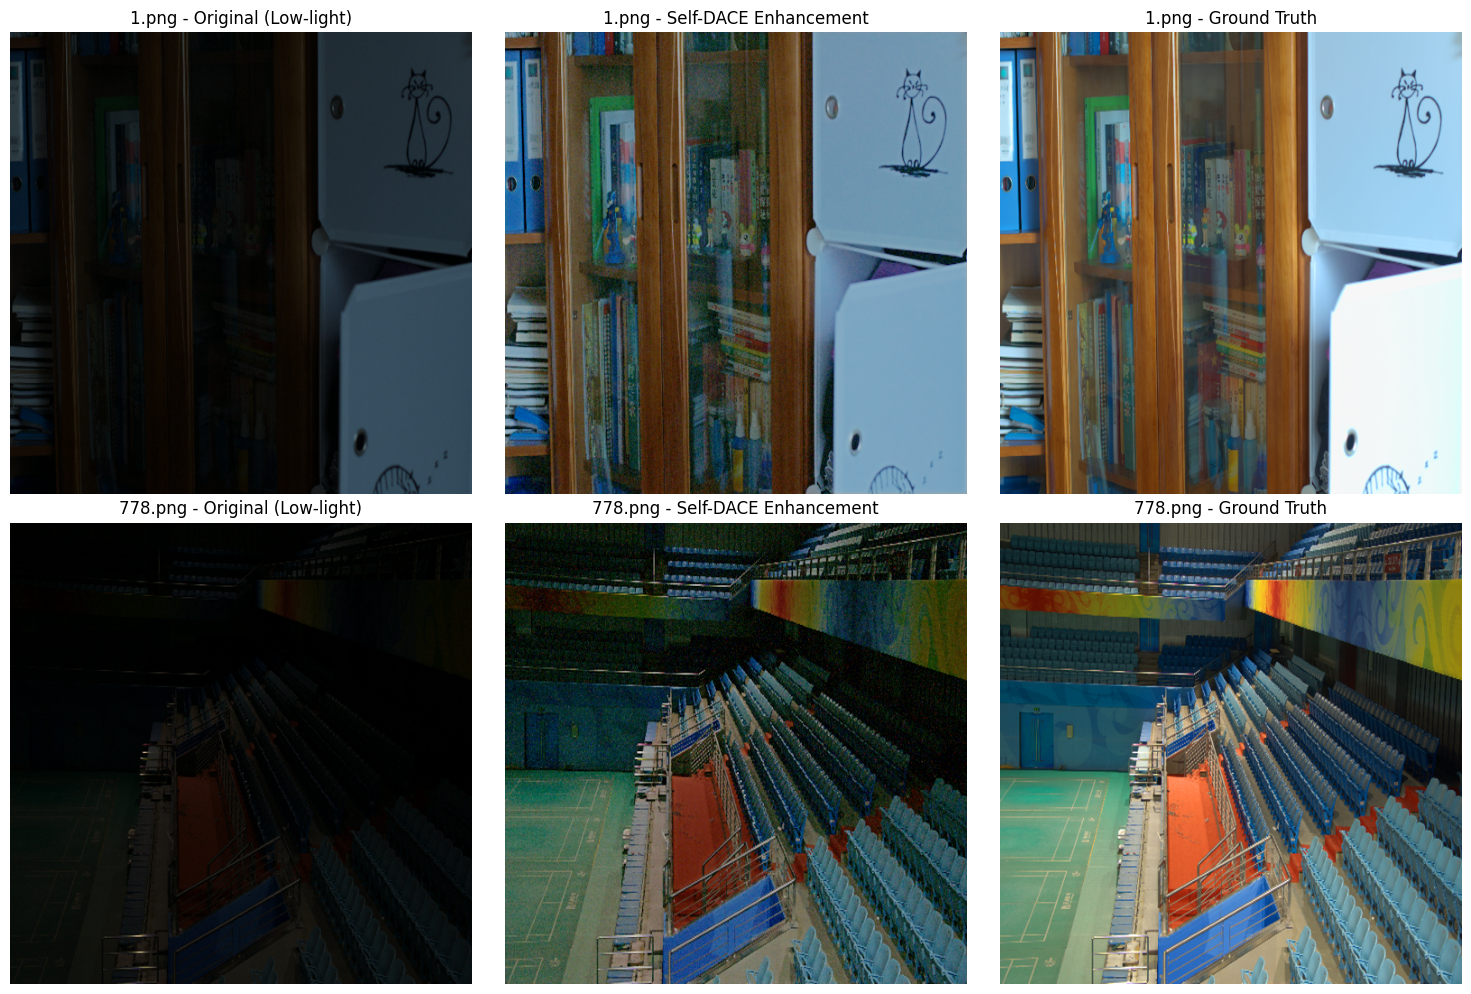

In [ ]:
# LOL Dataset Comparison - Images 1 and 778 (as shown in paper)

# LOL dataset paths (using eval15 dataset)
lol_low_dir = r"data\LOLdataset\eval15\low"
lol_high_dir = r"data\LOLdataset\eval15\high"

# Specific images mentioned in paper for visual examples
target_images = ["1.png", "778.png"]

results = {}

for img_name in target_images:
    low_path = os.path.join(lol_low_dir, img_name)
    high_path = os.path.join(lol_high_dir, img_name)

    if os.path.exists(low_path) and os.path.exists(high_path):
        print(f"\nProcessing {img_name}...")

        # Load images
        low_img = Image.open(low_path).convert("RGB")
        high_img = Image.open(high_path).convert("RGB")

        # Resize to consistent size
        low_img = low_img.resize((512, 512))
        high_img = high_img.resize((512, 512))

        # Convert to tensor
        input_tensor = (
            torch.from_numpy(np.array(low_img)).permute(2, 0, 1).float() / 255.0
        )
        input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

        # Enhance with model - unpack the tuple (enhanced, alphas, betas)
        with torch.no_grad():
            enhanced_tensor, _, _ = model(input_tensor, alpha_scale=0.7)

        # Convert back to PIL
        enhanced_np = enhanced_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        enhanced_np = np.clip(enhanced_np, 0, 1)
        enhanced_img = Image.fromarray((enhanced_np * 255).astype(np.uint8))

        # Calculate metrics comparing enhanced to ground truth
        gt_tensor = (
            torch.from_numpy(np.array(high_img)).permute(2, 0, 1).float() / 255.0
        )
        gt_tensor = gt_tensor.unsqueeze(0).to(DEVICE)

        metrics = calculate_metrics(enhanced_tensor, gt_tensor)
        results[img_name] = {
            "low": low_img,
            "enhanced": enhanced_img,
            "ground_truth": high_img,
            "metrics": metrics,
        }

        print(f"PSNR: {metrics['psnr']:.2f} dB")
        print(f"SSIM: {metrics['ssim']:.4f}")
    else:
        print(f"Images not found for {img_name}")

# Create comparison visualization for paper images
if results:
    n_images = len(results)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5 * n_images))

    # Handle single image case properly
    if n_images == 1:
        axes = axes.reshape(1, -1)

    for i, (img_name, data) in enumerate(results.items()):
        # Original (low-light)
        axes[i, 0].imshow(data["low"])
        axes[i, 0].set_title(f"{img_name} - Original (Low-light)")
        axes[i, 0].axis("off")

        # Our Enhancement
        axes[i, 1].imshow(data["enhanced"])
        axes[i, 1].set_title(f"{img_name} - Self-DACE Enhancement")
        axes[i, 1].axis("off")

        # Ground Truth
        axes[i, 2].imshow(data["ground_truth"])
        axes[i, 2].set_title(f"{img_name} - Ground Truth")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Full Eval15 Dataset Evaluation
all_results = []
low_files = glob.glob(os.path.join(lol_low_dir, "*.png"))
high_files = glob.glob(os.path.join(lol_high_dir, "*.png"))

print(
    f"Found {len(low_files)} low-light images and {len(high_files)} ground truth images"
)

for low_file in low_files:
    img_name = os.path.basename(low_file)
    high_file = os.path.join(lol_high_dir, img_name)

    if os.path.exists(high_file):
        print(f"Processing {img_name}...")

        # Load images
        low_img = Image.open(low_file).convert("RGB")
        high_img = Image.open(high_file).convert("RGB")

        # Resize to consistent size
        low_img = low_img.resize((512, 512))
        high_img = high_img.resize((512, 512))

        # Convert to tensor
        input_tensor = (
            torch.from_numpy(np.array(low_img)).permute(2, 0, 1).float() / 255.0
        )
        input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

        # Enhance with model - unpack the tuple (enhanced, alphas, betas)
        with torch.no_grad():
            enhanced_tensor, _, _ = model(input_tensor, alpha_scale=0.7)

        # Calculate metrics comparing enhanced to ground truth
        gt_tensor = (
            torch.from_numpy(np.array(high_img)).permute(2, 0, 1).float() / 255.0
        )
        gt_tensor = gt_tensor.unsqueeze(0).to(DEVICE)

        metrics = calculate_metrics(enhanced_tensor, gt_tensor)
        all_results.append(
            {
                "image": img_name,
                "psnr": metrics["psnr"],
                "ssim": metrics["ssim"],
            }
        )

        print(f"  PSNR: {metrics['psnr']:.2f} dB, SSIM: {metrics['ssim']:.4f}")

# Calculate and display dataset statistics
if all_results:
    psnr_values = [r["psnr"] for r in all_results]
    ssim_values = [r["ssim"] for r in all_results]

    print(f"Number of images evaluated: {len(all_results)}")
    print(f"PSNR:  {np.mean(psnr_values):.2f} dB")
    print(f"SSIM:  {np.mean(ssim_values):.4f}")
else:
    print("No images were successfully processed")

Found 15 low-light images and 15 ground truth images
Processing 1.png...


  PSNR: 15.31 dB, SSIM: 0.8425
Processing 111.png...
  PSNR: 15.16 dB, SSIM: 0.8824
Processing 146.png...
  PSNR: 15.16 dB, SSIM: 0.8824
Processing 146.png...
  PSNR: 19.14 dB, SSIM: 0.9496
Processing 179.png...
  PSNR: 19.14 dB, SSIM: 0.9496
Processing 179.png...
  PSNR: 21.32 dB, SSIM: 0.8896
Processing 22.png...
  PSNR: 21.32 dB, SSIM: 0.8896
Processing 22.png...
  PSNR: 15.77 dB, SSIM: 0.9037
Processing 23.png...
  PSNR: 15.77 dB, SSIM: 0.9037
Processing 23.png...
  PSNR: 9.44 dB, SSIM: 0.6539
Processing 493.png...
  PSNR: 9.44 dB, SSIM: 0.6539
Processing 493.png...
  PSNR: 19.46 dB, SSIM: 0.8617
Processing 547.png...
  PSNR: 19.46 dB, SSIM: 0.8617
Processing 547.png...
  PSNR: 24.03 dB, SSIM: 0.9191
Processing 55.png...
  PSNR: 24.03 dB, SSIM: 0.9191
Processing 55.png...
  PSNR: 9.02 dB, SSIM: 0.6318
Processing 665.png...
  PSNR: 9.02 dB, SSIM: 0.6318
Processing 665.png...
  PSNR: 11.69 dB, SSIM: 0.6450
Processing 669.png...
  PSNR: 11.69 dB, SSIM: 0.6450
Processing 669.png...
  P


Generating iteration steps for 1.png...

Generating iteration steps for 778.png...


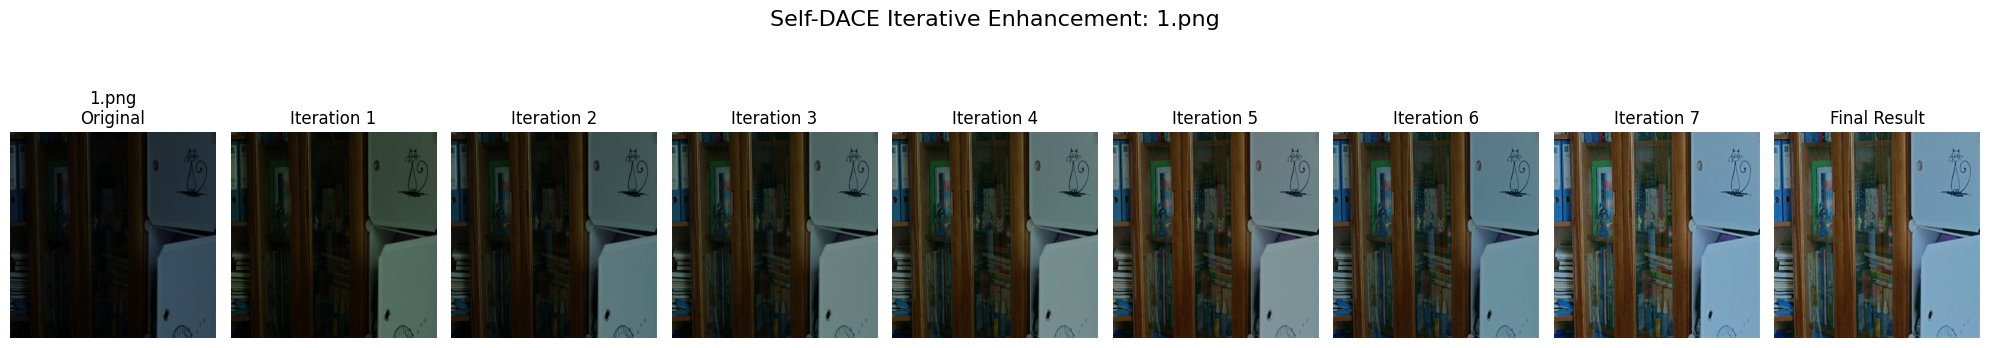

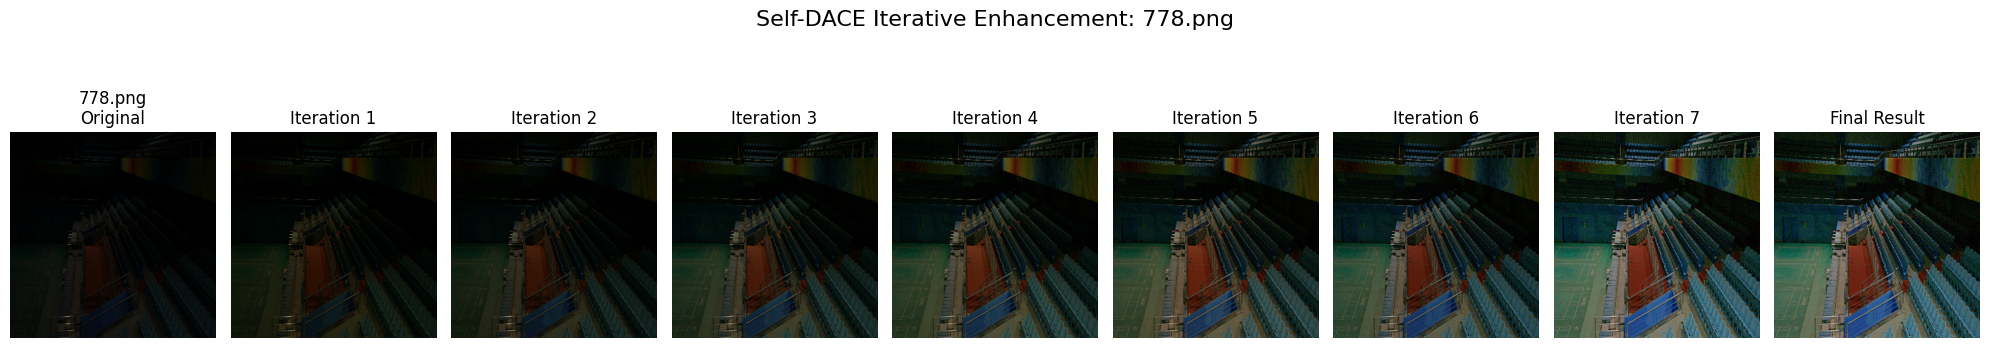

In [ ]:
# Process images 1 and 778 to show iteration steps
iteration_results = {}

for img_name in ["1.png", "778.png"]:
    low_path = os.path.join(lol_low_dir, img_name)

    if os.path.exists(low_path):
        print(f"\nGenerating iteration steps for {img_name}...")

        # Load and prepare image
        low_img = Image.open(low_path).convert("RGB")
        low_img = low_img.resize((512, 512))
        input_tensor = (
            torch.from_numpy(np.array(low_img)).permute(2, 0, 1).float() / 255.0
        )
        input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

        # Get iterative enhancement steps
        with torch.no_grad():
            enhanced_final, alphas, betas, intermediates = model(
                input_tensor, output_intermediate_images=True, alpha_scale=0.7
            )

        # Convert all intermediate steps to PIL images
        intermediate_pils = []
        for step_tensor in intermediates:
            step_np = step_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
            step_np = np.clip(step_np, 0, 1)
            step_pil = Image.fromarray((step_np * 255).astype(np.uint8))
            intermediate_pils.append(step_pil)

        iteration_results[img_name] = {
            "original": low_img,
            "intermediates": intermediate_pils,
            "final": Image.fromarray(
                (
                    enhanced_final.squeeze(0).cpu().permute(1, 2, 0).clamp(0, 1).numpy()
                    * 255
                ).astype(np.uint8)
            ),
        }

# Create separate iterative visualizations for each image
if iteration_results:
    n_steps = 9  # Original + 7 iterations + Final

    for img_name, data in iteration_results.items():
        # Create individual figure for this image
        fig, axes = plt.subplots(1, n_steps, figsize=(20, 4))

        # Original image
        axes[0].imshow(data["original"])
        axes[0].set_title(f"{img_name}\nOriginal")
        axes[0].axis("off")

        # Intermediate steps (iterations 1-7)
        for step in range(7):
            axes[step + 1].imshow(data["intermediates"][step])
            axes[step + 1].set_title(f"Iteration {step + 1}")
            axes[step + 1].axis("off")

        # Final result
        axes[8].imshow(data["final"])
        axes[8].set_title("Final Result")
        axes[8].axis("off")

        plt.suptitle(
            f"Self-DACE Iterative Enhancement: {img_name}", fontsize=16, y=1.02
        )
        plt.tight_layout()

        # Save each iteration visualization separately
        plt.show()
        plt.close()  # Add this to properly close the figure